# COSC 6373 - HW9-ICA - Minh Nguyen #2069407

In [85]:
import os
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from sklearn.neighbors import KernelDensity

Found 733 files.
Using 660 files for training.
Found 733 files.
Using 73 files for validation.
Found 764 files.
Found 1052 files.
Found 784 files.
Found 984 files.
Found 733 files.
Using 73 files for validation.


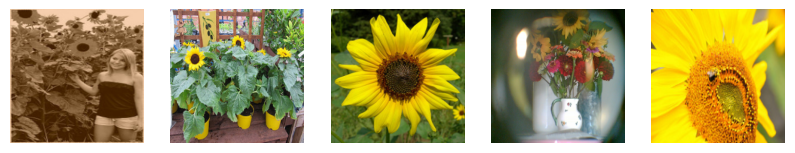

In [86]:
# Create generators for training, validation and testing
# Generate data from the images in a folder, allows use of datasets that do not fit in main memory all at once
# Image resizing is done by the generator so a folder with any sized-images can be used

DATASET_PATH = 'flowers'
BATCH_SIZE = 32
IMG_SIZE = 224
TARGET_SIZE = (224, 224)
VALIDATION_SPLIT = 0.1 # 10% validation split

# Function to load images from a directory
def load_dataset(flower_type, subset=None):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(DATASET_PATH, flower_type),  # Load from specific class directory
        label_mode=None,  # We don't need class labels
        image_size=(IMG_SIZE, IMG_SIZE),  # Resize images
        batch_size=BATCH_SIZE,
        interpolation="bilinear",  # Preserve features
        subset=subset,
        validation_split=VALIDATION_SPLIT if subset else None,
        seed=42
    )
    
    # Normalize images (convert range from [0,255] to [0,1])
    # set labels to be the same as the images
    # dataset = dataset.map(lambda x: x / 255.0)
    dataset = dataset.map(lambda x: (x / 255.0, x / 255.0))

    return dataset

# Load sunflower dataset with split
sunflower_train = load_dataset("sunflower", subset="training")  # 90% for training
sunflower_val = load_dataset("sunflower", subset="validation")  # 10% for validation

# Load other flowers (full dataset for testing)
daisy_dataset = load_dataset("daisy", subset=None)
dandelion_dataset = load_dataset("dandelion", subset=None)
rose_dataset = load_dataset("rose", subset=None)
tulip_dataset = load_dataset("tulip", subset=None)

# Load 10% of sunflower data again for testing
sunflower_test = load_dataset("sunflower", subset="validation")

# Combine test dataset (10% sunflower + all other flowers)
test_dataset = sunflower_test.concatenate(daisy_dataset).concatenate(rose_dataset).concatenate(dandelion_dataset).concatenate(tulip_dataset)

# Check some images from training set
plt.figure(figsize=(10, 5))
for image_batch in sunflower_train.take(1):  
    for i in range(5):  
        ax = plt.subplot(1, 5, i + 1)
        plt.imshow(image_batch[0][i].numpy())
        plt.axis("off")
plt.show()

In [87]:
# Define the convolutional autoencoder model 
# input shape must be the same size as the images that will be fed into it by the generators
# The output layer must be the same dimensions as the original image
# model = Sequential()

# # Encoder
# model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(224, 224, 3)))
# model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

# model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
# model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

# model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
# model.add(MaxPooling2D(pool_size=(2,2), padding='same'))  # Bottleneck: (28,28,8)


# # Decoder
# model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
# model.add(UpSampling2D((2, 2)))

# model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
# model.add(UpSampling2D((2, 2)))

# model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
# model.add(UpSampling2D((2, 2)))

# model.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))  # Output shape: (224,224,3)

# # Compile the model
# # model.compile(optimizer='adadelta', loss='mean_squared_error')
# model.compile(optimizer='adam', loss='mean_squared_error')

# model.summary()

In [88]:
# Define the convolutional autoencoder model
input_layer = Input(shape=(224, 224, 3))
# x = Conv2D(32, (3, 3), padding='same', activation='relu')(input_layer)
x = Conv2D(32, (3, 3), padding='same', activation='sigmoid')(input_layer)
x = MaxPooling2D(pool_size=(2,2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2,2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D(pool_size=(2,2), padding='same')(x)  # Bottleneck: (28,28,8)

# Decoder
y = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
y = UpSampling2D((2, 2))(y)
y = Conv2D(16, (3, 3), activation='relu', padding='same')(y)
y = UpSampling2D((2, 2))(y)
y = Conv2D(32, (3, 3), activation='relu', padding='same')(y)
y = UpSampling2D((2, 2))(y)
output_layer = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(y)  # Output shape: (224,224,3)

model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 112, 112, 16)   │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 56, 56, 8)      │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 28, 28, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 28, 28, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_15 (UpSampling2D) │ (None, 56, 56, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 56, 56, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_16 (UpSampling2D) │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_17 (UpSampling2D) │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 224, 224, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,939 (54.45 KB)

 Trainable params: 13,939 (54.45 KB)

 Non-trainable params: 0 (0.00 B)

In [89]:
# Train the model
model.fit(sunflower_train, validation_data=sunflower_val, epochs=10)
# model.fit(sunflower_train, validation_data=sunflower_val, epochs=10, steps_per_epoch=len(sunflower_train))

Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 13s 564ms/step - loss: 0.0823 - val_loss: 0.0756
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 529ms/step - loss: 0.0724 - val_loss: 0.0527
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 524ms/step - loss: 0.0479 - val_loss: 0.0381
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 531ms/step - loss: 0.0382 - val_loss: 0.0326
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 539ms/step - loss: 0.0325 - val_loss: 0.0249
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 545ms/step - loss: 0.0248 - val_loss: 0.0218
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 542ms/step - loss: 0.0214 - val_loss: 0.0203
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 558ms/step - loss: 0.0194 - val_loss: 0.0195
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 530ms/step - loss: 0.0188 - val_loss: 0.0187
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 534ms/step - loss: 0.0181 - val_loss: 0.0182


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


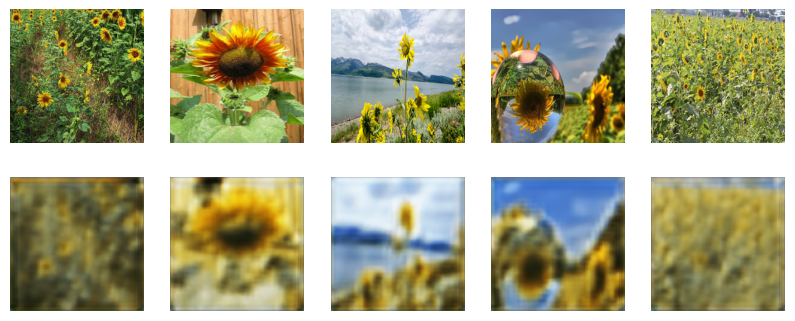

In [90]:
# Function to visualize original vs reconstructed images
def display_reconstructed_images(dataset, model, num_images=5):
    batch = next(iter(dataset.take(1)))[0].numpy()  # Convert tensor to NumPy
    reconstructed_images = model.predict(batch)
    
    plt.figure(figsize=(10, 4))
    for i in range(num_images):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(batch[i])
        plt.axis('off')
        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(reconstructed_images[i])
        plt.axis('off')
    plt.show()

# Display reconstruction results on sunflower validation images
display_reconstructed_images(sunflower_val, model)

In [91]:
# Evaluate the Autoencoder to each one of the other flower types to detect anomalies
# and find the MSE between the normal and anomalous images.

# Evaluate the model on daisy images
daisy_mse = model.evaluate(daisy_dataset)
print(f"Daisy MSE: {daisy_mse}")

# Evaluate the model on dandelion images
dandelion_mse = model.evaluate(dandelion_dataset)
print(f"Dandelion MSE: {dandelion_mse}")

# Evaluate the model on rose images
rose_mse = model.evaluate(rose_dataset)
print(f"Rose MSE: {rose_mse}")

# Evaluate the model on tulip images
tulip_mse = model.evaluate(tulip_dataset)
print(f"Tulip MSE: {tulip_mse}")

# Evaluate the model on sunflower images (10% of the dataset)
sunflower_mse = model.evaluate(sunflower_test)
print(f"Sunflower MSE: {sunflower_mse}")

# Evaluate the model on all images (sunflower + other flowers)
test_mse = model.evaluate(test_dataset)
print(f"Test MSE: {test_mse}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - loss: 0.0159
Daisy MSE: 0.015503820963203907
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - loss: 0.0113
Dandelion MSE: 0.011167307384312153
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - loss: 0.0200
Rose MSE: 0.020253827795386314
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - loss: 0.0216
Tulip MSE: 0.02189662866294384
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0185 
Sunflower MSE: 0.01819453202188015
116/116 ━━━━━━━━━━━━━━━━━━━━ 17s 147ms/step - loss: 0.0166
Test MSE: 0.017048511654138565


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

/var/folders/b5/174qqshj3px_y32r11qg8td40000gn/T/ipykernel_24480/3230945074.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([mse_daisy.flatten(), mse_dandelion.flatten(),


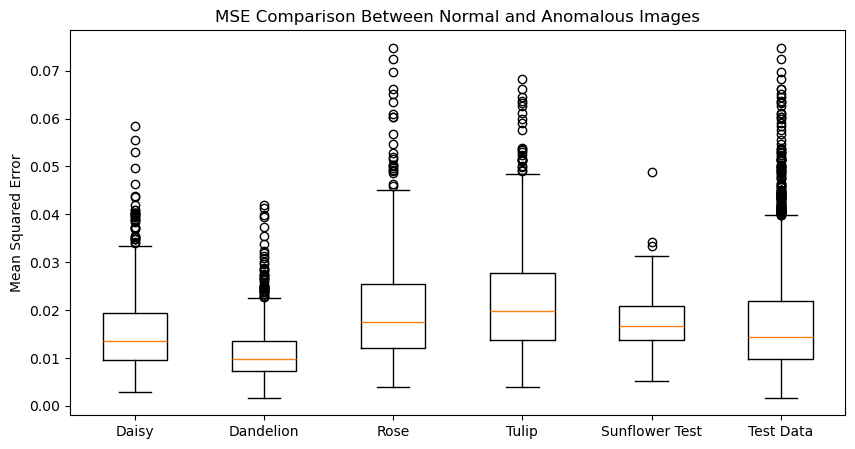

In [92]:
# Function to compute Mean Squared Error (MSE) for a dataset
def compute_mse(dataset, model):
    mse_list = []
    for batch in dataset:
        reconstructed = model.predict(batch[0])
        # mse = np.mean(np.square(batch - reconstructed), axis=(1, 2, 3))  # Compute per-image MSE
        mse = np.mean(np.square(batch[0] - reconstructed), axis=(1, 2, 3))  # Compute per-image MSE
        mse_list.extend(mse)
    return np.array(mse_list)

# Compute MSE for each dataset
mse_daisy = compute_mse(daisy_dataset, model)
mse_dandelion = compute_mse(dandelion_dataset, model)
mse_rose = compute_mse(rose_dataset, model)
mse_tulip = compute_mse(tulip_dataset, model)
mse_sunflower = compute_mse(sunflower_test, model)
mse_test = compute_mse(test_dataset, model)

# Plot MSE distribution for normal vs. anomalous images
plt.figure(figsize=(10, 5))
plt.boxplot([mse_daisy.flatten(), mse_dandelion.flatten(), 
             mse_rose.flatten(), mse_tulip.flatten(),
             mse_sunflower.flatten(), mse_test.flatten()], 
            labels=['Daisy', 'Dandelion', 'Rose', 'Tulip', 'Sunflower Test', 'Test Data'])
plt.ylabel("Mean Squared Error")
plt.title("MSE Comparison Between Normal and Anomalous Images")
plt.show()

In [93]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5)  # Reduce dimensions for KDE stability

# Define encoder separately
encoder = Model(inputs=model.input, outputs=encoded)

# Function to extract latent representations
def get_latent_features(dataset, encoder):
    latent_features = []
    for images, _ in dataset:
        encoded = encoder.predict(images)
        latent_features.append(encoded.reshape(encoded.shape[0], -1))
    # for batch in dataset:
    #     images = batch[0]  # Extract only images as dataset is returning (image, label)
    #     encoded = encoder.predict(images)
    #     latent_features.append(encoded.reshape(encoded.shape[0], -1))
    return np.vstack(latent_features)

# Extract latent features
latent_sunflower_train = get_latent_features(sunflower_train, encoder)

latent_sunflower_val = get_latent_features(sunflower_val, encoder)

latent_sunflower = get_latent_features(sunflower_test, encoder)
latent_daisy = get_latent_features(daisy_dataset, encoder)
latent_dandelion = get_latent_features(dandelion_dataset, encoder)
latent_rose = get_latent_features(rose_dataset, encoder)
latent_tulip = get_latent_features(tulip_dataset, encoder)

latent_test = get_latent_features(test_dataset, encoder)

print("Shape of latent_sunflower_train:", latent_sunflower_train.shape)
print("Shape of latent_sunflower_val:", latent_sunflower_val.shape)
print("Shape of latent_sunflower:", latent_sunflower.shape)

# Fit KDE to sunflower latent space
# kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(latent_sunflower)
# kde = KernelDensity(kernel='gaussian', bandwidth=1.0).fit(latent_sunflower_train)
latent_sunflower_train_pca = pca.fit_transform(latent_sunflower_train)
kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(latent_sunflower_train_pca)

def compute_density(latent_features, kde):
    # return kde.score_samples(latent_features)
    return kde.score_samples(pca.transform(latent_features))

# Compute density scores
print("Computing density scores...")
density_sunflower_train = compute_density(latent_sunflower_train, kde)

density_sunflower_val = compute_density(latent_sunflower_val, kde)

density_sunflower = compute_density(latent_sunflower, kde)
density_daisy = compute_density(latent_daisy, kde)
density_dandelion = compute_density(latent_dandelion, kde)
density_rose = compute_density(latent_rose, kde)
density_tulip = compute_density(latent_tulip, kde)

density_test = compute_density(latent_test, kde)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━

In [94]:
# print(np.var(latent_sunflower_train))
# print(np.var(latent_sunflower_val))
# print(np.var(latent_sunflower))

# print(density_sunflower_train[:10])  # Inspect first 10 values
# print(density_sunflower_val[:10])
# print(density_sunflower[:10])

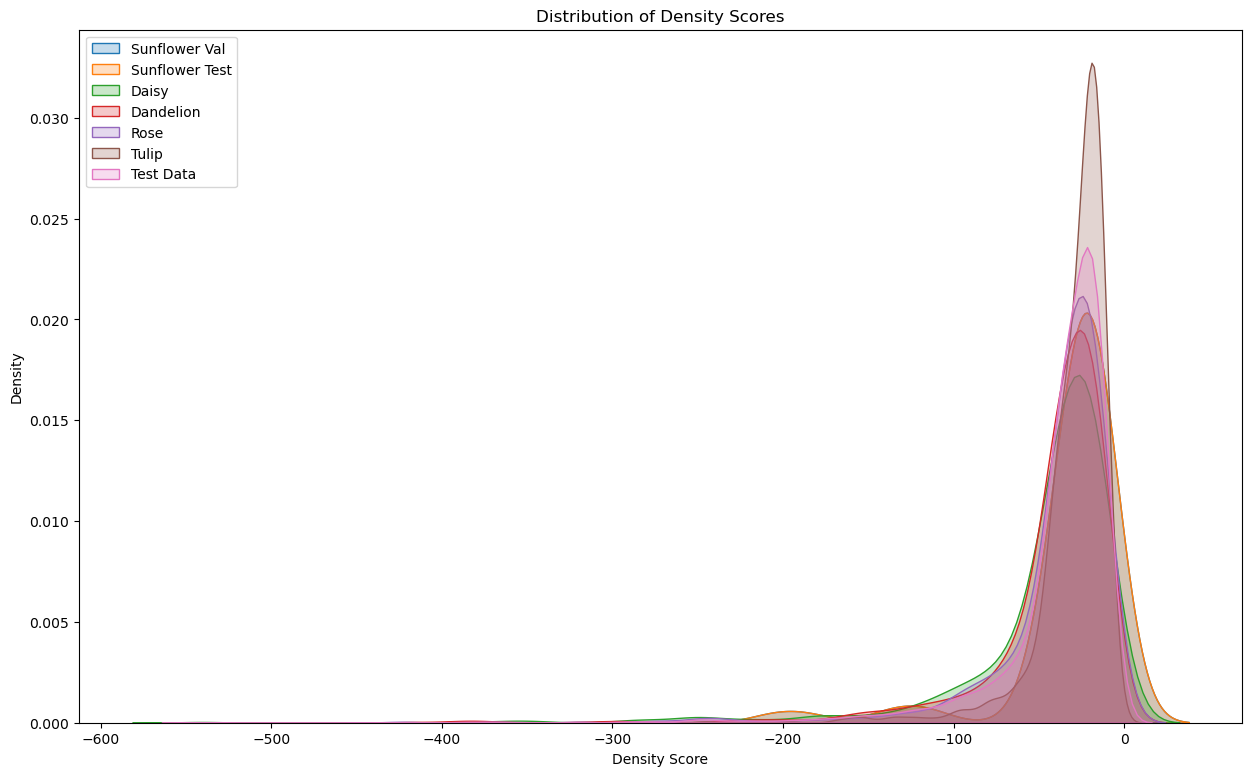

In [97]:
# Plot density distribution

plt.figure(figsize=(15, 9))
# sns.kdeplot(density_sunflower_train, label="Sunflower Train", fill=True)

sns.kdeplot(density_sunflower_val, label="Sunflower Val", fill=True)

sns.kdeplot(density_sunflower, label="Sunflower Test", fill=True)
sns.kdeplot(density_daisy, label="Daisy", fill=True)
sns.kdeplot(density_dandelion, label="Dandelion", fill=True)
sns.kdeplot(density_rose, label="Rose", fill=True)
sns.kdeplot(density_tulip, label="Tulip", fill=True)

sns.kdeplot(density_test, label="Test Data", fill=True)

# plt.hist(density_sunflower_train, alpha=0.5, label="Sunflower Train", density=True)
# plt.hist(density_sunflower_val, alpha=0.5, label="Sunflower Val", density=True)
# plt.hist(density_sunflower, alpha=0.5, label="Sunflower Test", density=True)
# plt.hist(density_daisy, alpha=0.5, label="Daisy", density=True)
# plt.hist(density_dandelion, alpha=0.5, label="Dandelion", density=True)
# plt.hist(density_rose, alpha=0.5, label="Rose", density=True)
# plt.hist(density_tulip, alpha=0.5, label="Tulip", density=True)
# plt.hist(density_test, alpha=0.5, label="Test Data", density=True)


plt.xlabel("Density Score")
plt.title("Distribution of Density Scores")
plt.legend()
plt.show()

5. How does the autoencoder work for anomaly detection?
An autoencoder works for anomaly detection by learning a representation of "normal" data through its encoding process, and then identifying data points that deviate significantly from this learned representation by calculating a reconstruction error, where large reconstruction errors indicate anomalies. The bigger the difference between the original data and its reconstructed version, the more likely it is an anomaly. 

6. What other methods can be used instead of autoencoders for anomaly detection?
Other methods that can be used for anomaly detection include:
- KNN: Anomaly detection can be performed by calculating the distance of each data point to its k-nearest neighbors, and identifying data points that are significantly different from their neighbors.
- One-Class Support Vector Machine (OCSVM): OCSVM is a type of SVM that learns a decision boundary around the normal data points, and identifies anomalies as data points that fall outside this boundary.
- etc.
